In [1]:
# Load our stuff
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
from Bio import SeqIO
from SHMModels.simulate_mutations import *
from SHMModels.fitted_models import ContextModel
import pkgutil
import logging
import os
import sys
import json
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
random.seed(1408)
import csv
import collections
# Load options
import pandas as pd
import glob
from random import sample
from sim_data.sumstats import *


Using TensorFlow backend.


In [2]:
data = []
with open("./sim_data/data.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        data.append(row)
data = [s for s in data if len(s) == 112]
data = np.array(data)

train_X = data[data[:,111]==0][:,0:105]
train_theta = data[data[:,111]==0][:,105:111]
test_X = data[data[:,111]==1][:,0:105]
test_theta = data[data[:,111]==1][:,105:111]


x_mean = np.mean(train_X, axis =0)
x_sd = np.std(train_X, axis =0)
mean = np.mean(train_theta, axis =0)
std = np.std(train_theta, axis =0)


FileNotFoundError: [Errno 2] No such file or directory: './sim_data/data.csv'

In [ ]:
np.where([len(data[i]) != 112 for i in range(len(data))])

(array([], dtype=int64),)

In [ ]:
np.concatenate((test_X,test_theta[10:,:]),axis = 1)

array([[ 8.25263338,  7.80395566,  9.97892714, ..., 18.28374938,
        13.3218649 ,  0.76201044],
       [ 6.25497588,  6.42284587,  4.79809107, ...,  7.70236207,
        11.89878679,  0.35852874],
       [ 6.17937263,  5.40545448,  6.045355  , ...,  3.40452654,
        18.04585778,  0.18390387],
       ...,
       [ 6.74501304,  6.60003462,  6.72855204, ...,  3.03218837,
         4.12370025,  0.4275299 ],
       [ 4.51963866,  4.18377293,  4.2755598 , ..., 16.94723522,
        17.66674649,  0.03266881],
       [ 5.26483258,  4.15150758,  4.62858773, ...,  4.07392276,
        16.56438165,  0.6363493 ]])

In [ ]:
data = pd.DataFrame(np.concatenate((test_X,test_theta[10:,:],np.ones((910,1))),axis = 1))

In [ ]:
data = data.append(pd.DataFrame(np.concatenate((train_X[0:9000,:],train_theta,np.zeros((9000,1))),axis = 1)))

/tmp/ipykernel_4314/442598312.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(pd.DataFrame(np.concatenate((train_X[0:9000,:],train_theta,np.zeros((9000,1))),axis = 1)))


In [ ]:
data.iloc[:,111]

0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
8995    0.0
8996    0.0
8997    0.0
8998    0.0
8999    0.0
Name: 111, Length: 9910, dtype: float64

In [ ]:
data.iloc[:,0:105][data.iloc[:,111] == 1]

,0,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,8.252633,7.803956,9.978927,7.902800,9.217894,7.879990,5.848898,5.574748,5.706149,5.043310,...,0.028270,0.375967,0.128981,0.108181,0.011007,1.207547,31.132318,0.634110,0.003728,0.455401
1,6.254976,6.422846,4.798091,4.991370,4.107495,4.470670,3.726578,5.677485,6.423595,4.066658,...,0.317648,0.264165,0.298841,0.240369,0.187360,1.167939,43.343245,0.348771,0.003858,0.310059
2,6.179373,5.405454,6.045355,4.594865,4.218672,5.813145,5.326148,4.495176,5.157037,4.443464,...,0.260405,0.258317,0.199019,0.291957,0.185233,1.185237,50.298788,0.562119,0.010462,0.308977
3,6.236738,7.295254,7.384764,6.561430,5.696213,6.194292,7.247740,6.289327,4.693809,6.300865,...,0.203602,0.148954,0.063255,0.114433,0.079790,1.187410,41.501650,0.542146,0.003686,0.569662
4,6.337815,6.728390,6.309113,6.545473,4.673231,5.432404,6.724373,4.498651,4.385101,4.844558,...,0.084460,0.099668,0.226249,0.125551,0.120172,1.171210,39.475346,0.444853,0.004026,0.692075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,5.403470,4.752585,4.244955,5.043905,4.585685,3.631134,3.492293,3.543953,3.333918,3.064951,...,0.771437,0.659499,0.378949,0.536324,0.872177,1.182331,80.958512,0.558980,0.012598,0.683335
906,5.111062,4.766720,4.448807,4.081696,3.935211,3.920839,3.808450,4.033970,4.007903,3.227423,...,0.561672,0.576552,0.483744,0.397095,0.548978,1.170601,76.885454,0.667150,0.017442,0.519889
907,6.745013,6.600035,6.728552,5.350464,6.790521,5.274358,5.212976,5.409602,4.516752,5.115766,...,0.243661,0.161499,0.144096,0.193884,0.090436,1.098204,46.393643,0.289895,0.004031,0.315571
908,4.519639,4.183773,4.275560,4.544522,4.326204,4.150740,3.685613,3.445946,3.468801,2.938572,...,0.457167,0.640832,0.689044,0.469802,0.555967,1.192606,79.813659,0.440906,0.017150,0.710256


In [3]:
model = keras.models.load_model('model')

OSError: Unable to open file (unable to open file: name = 'model', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
df = pd.read_pickle("sim_data/full_edge_df.pk1")
parent_sample= df['orig_seq']
obs_sample = df['mut_seq']
colocals = colocal_vector(parent_sample, obs_sample)
exo = np.concatenate([get_exo_summ(obs_sample[i],parent_sample[i]) for i in range(len(parent_sample))]).ravel().tolist()
at = np.concatenate([get_pairwise_at(obs_sample[i],parent_sample[i]) for i in range(len(parent_sample))]).ravel().tolist()
c_counts, g_counts = get_cg_summ_sample(obs_sample,parent_sample)
bp = base_prob(obs_sample,parent_sample)
atp = at_frac(obs_sample,parent_sample)
summ_stat = np.append(colocals,[np.mean(exo),np.mean(at), np.sum(c_counts)/(np.sum(c_counts) + np.sum(g_counts)), bp,atp])

In [ ]:
summ_stat_cent = (summ_stat-x_mean)/x_sd


In [ ]:
params = model.predict(summ_stat_cent.reshape(1,105))*std + mean

1/1 [==============================] - 0s 149ms/step


In [ ]:
params = params[0]
params

array([-9.71396504,  6.9732454 ,  0.51655939, 18.22189314, 14.75165542,
        0.657664  ])

In [ ]:
lower = np.zeros(100)
upper = np.zeros(100)

for i in range(100):
    lower[i] = np.quantile(train_X[:,i],0.1)
    upper[i] = np.quantile(train_X[:,i],0.90)

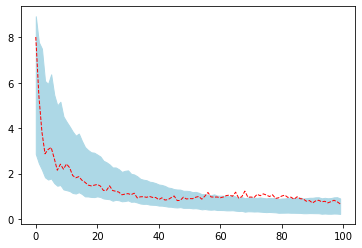

In [ ]:
plt.fill_between(range(100),lower,upper, color = 'lightblue')
plt.plot(summ_stat[0:100], color='red', linestyle='dashed', linewidth=1)

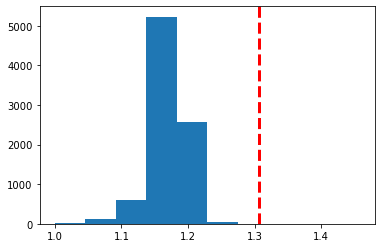

In [ ]:
plt.hist(train_X[:,100])
plt.axvline(summ_stat[100], color='red', linestyle='dashed', linewidth=3)

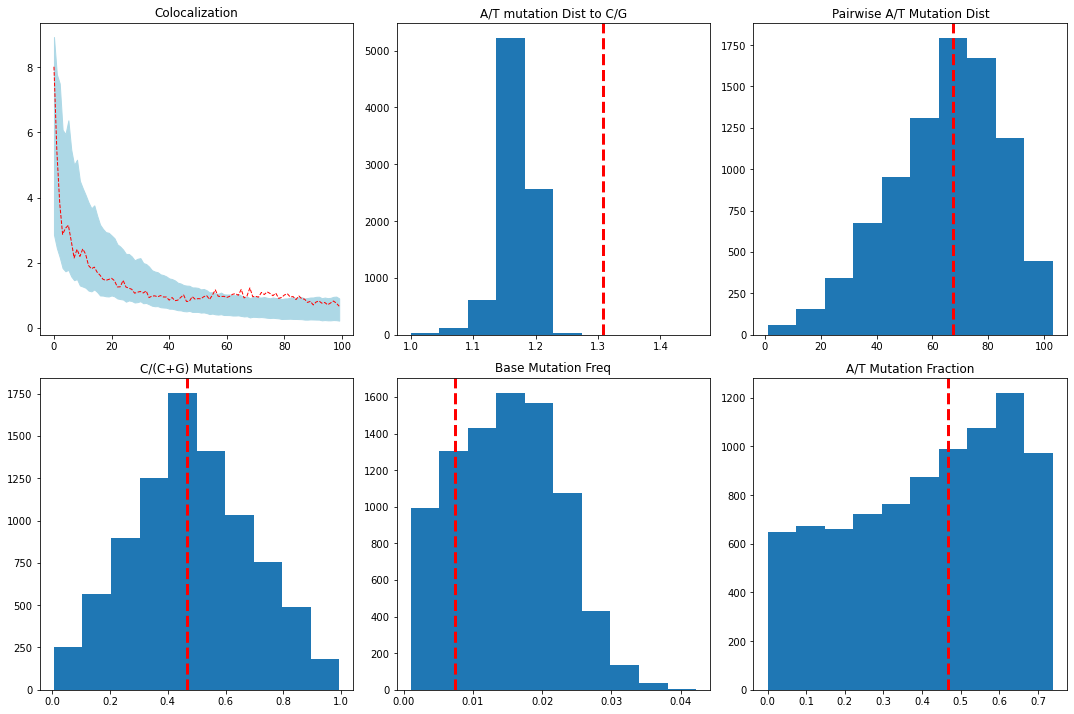

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
  
# For Sine Function
axis[0, 0].fill_between(range(100),lower,upper, color = 'lightblue')
axis[0,0].plot(summ_stat[0:100], color='red', linestyle='dashed', linewidth=1)
axis[0, 0].set_title("Colocalization")
  
# For Cosine Function
axis[0, 1].hist(train_X[:,100])
axis[0, 1].axvline(summ_stat[100], color='red', linestyle='dashed', linewidth=3)
axis[0, 1].set_title("A/T mutation Dist to C/G")

# For Cosine Function
axis[0, 2].hist(train_X[:,101])
axis[0, 2].axvline(summ_stat[101], color='red', linestyle='dashed', linewidth=3)
axis[0, 2].set_title("Pairwise A/T Mutation Dist")
# For Cosine Function
axis[1, 0].hist(train_X[:,102])
axis[1, 0].axvline(summ_stat[102], color='red', linestyle='dashed', linewidth=3)
axis[1, 0].set_title("C/(C+G) Mutations")
# For Cosine Function
axis[1, 1].hist(train_X[:,103])
axis[1, 1].axvline(summ_stat[103], color='red', linestyle='dashed', linewidth=3)
axis[1, 1].set_title("Base Mutation Freq")
# For Cosine Function
axis[1, 2].hist(train_X[:,104])
axis[1, 2].axvline(summ_stat[104], color='red', linestyle='dashed', linewidth=3)
axis[1, 2].set_title("A/T Mutation Fraction")
figure.set_figheight(10)
figure.set_figwidth(15)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
plt.savefig('figures/summ_stat.png')
plt.show()

In [122]:
params

array([-9.71396504,  6.9732454 ,  0.51655939, 18.22189314, 14.75165542,
        0.657664  ])

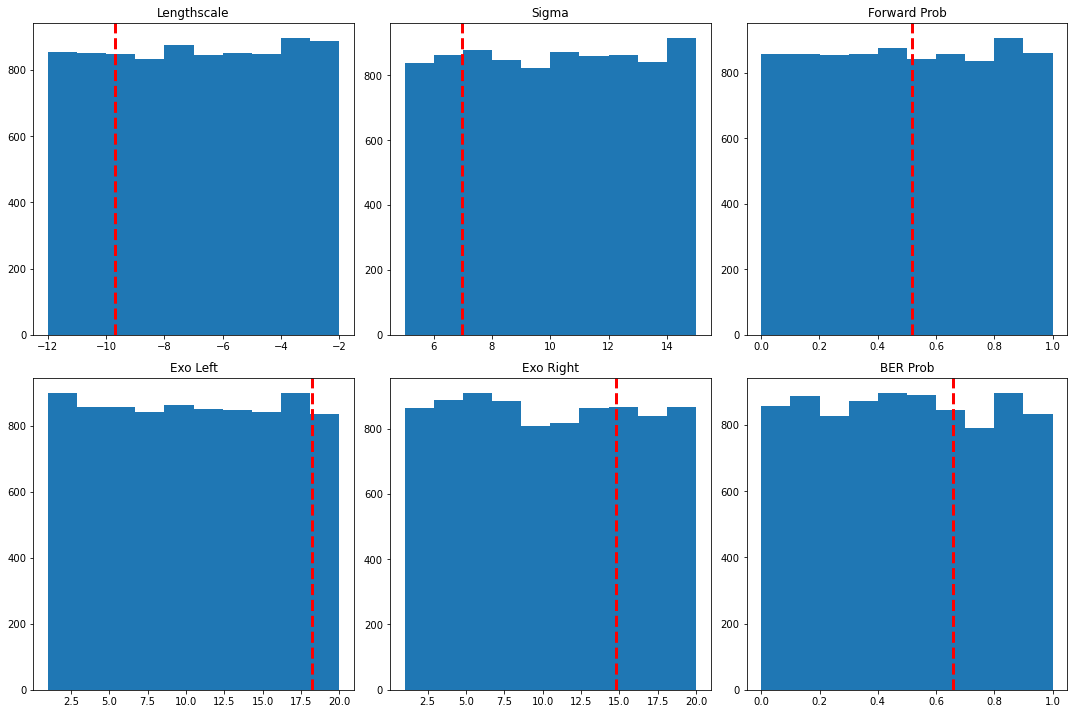

In [123]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
# For Sine Function
axis[0, 0].hist(train_theta[:,0])
axis[0, 0].axvline(params[0], color='red', linestyle='dashed', linewidth=3)
axis[0, 0].set_title("Lengthscale")
  
# For Sine Function
axis[0, 1].hist(train_theta[:,1])
axis[0, 1].axvline(params[1], color='red', linestyle='dashed', linewidth=3)
axis[0, 1].set_title("Sigma")
  
# For Cosine Function# For Sine Function
axis[0, 2].hist(train_theta[:,2])
axis[0, 2].axvline(params[2], color='red', linestyle='dashed', linewidth=3)
axis[0, 2].set_title("Forward Prob")
  
# For Cosine Function# For Sine Function
axis[1, 0].hist(train_theta[:,3])
axis[1, 0].axvline(params[3], color='red', linestyle='dashed', linewidth=3)
axis[1, 0].set_title("Exo Left")
  
# For Cosine Function# For Sine Function
axis[1, 1].hist(train_theta[:,4])
axis[1, 1].axvline(params[4], color='red', linestyle='dashed', linewidth=3)
axis[1, 1].set_title("Exo Right")
  
# For Cosine Function# For Sine Function
axis[1, 2].hist(train_theta[:,5])
axis[1, 2].axvline(params[5], color='red', linestyle='dashed', linewidth=3)
axis[1, 2].set_title("BER Prob")
  
# For Cosine Function
figure.set_figheight(10)
figure.set_figwidth(15)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
plt.savefig('figures/real_hist.png')
plt.show()

In [14]:
params

array([-10.95518256,   5.62844507,   0.56139752,  15.24284578,
        18.89962825,   0.51447639])

In [ ]:
preds = np.load('preds_0.npy')
labels = np.load('labels_0.npy')

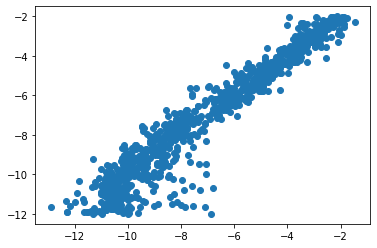

In [91]:
plt.scatter(preds[:,0],labels[:,0])

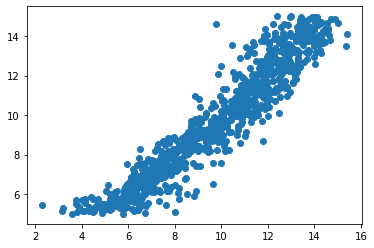

In [92]:
plt.scatter(preds[:,1],labels[:,1])

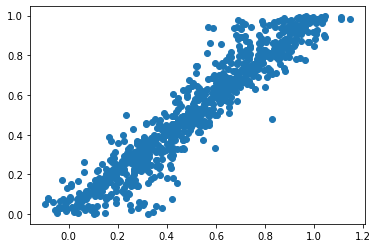

In [93]:
plt.scatter(preds[:,2],labels[:,2])

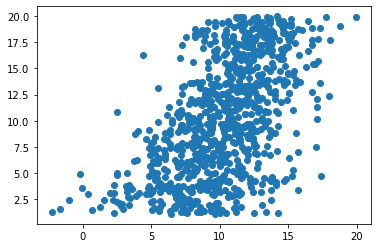

In [94]:
plt.scatter(preds[:,3],labels[:,3])

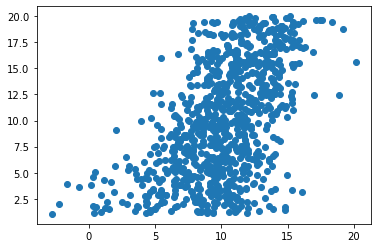

In [95]:
plt.scatter(preds[:,4],labels[:,4])

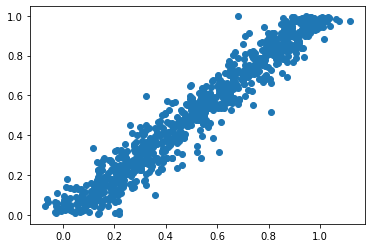

In [96]:
plt.scatter(preds[:,5],labels[:,5])

In [ ]:
import csv
data = []
with open("sim_data/data.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        data.append(row)

In [23]:
len(train_X[:,0])

9100

In [24]:
data[data[:,111]==0][0,105:112]

TypeError: list indices must be integers or slices, not tuple

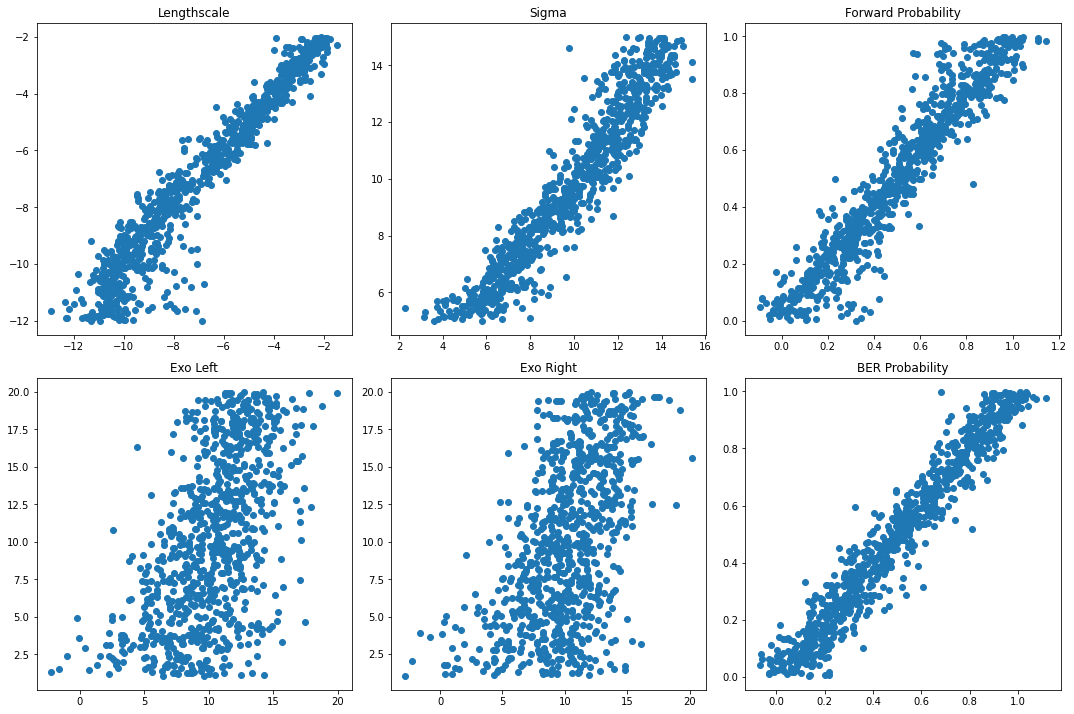

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
  
# For Sine Function
axis[0, 0].scatter(preds[:,0], labels[:,0])
axis[0, 0].set_title("Lengthscale")
  
# For Cosine Function
axis[0, 1].scatter(preds[:,1], labels[:,1])
axis[0, 1].set_title("Sigma")
  
# For Tangent Function
axis[0, 2].scatter(preds[:,2], labels[:,2])
axis[0, 2].set_title("Forward Probability")
  
# For Sine Function
axis[1, 0].scatter(preds[:,3], labels[:,3])
axis[1, 0].set_title("Exo Left")
  
# For Cosine Function
axis[1, 1].scatter(preds[:,4], labels[:,4])
axis[1, 1].set_title("Exo Right")
  
# For Tangent Function
axis[1, 2].scatter(preds[:,5], labels[:,5])
axis[1, 2].set_title("BER Probability")
figure.set_figheight(10)
figure.set_figwidth(15)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
plt.savefig('figures/scatter.png')
plt.show()


In [28]:
np.corrcoef(preds[:,3], labels[:,3])**2

array([[1.        , 0.27162282],
       [0.27162282, 1.        ]])

In [2]:
data = []
with open("./sim_data/data.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        data.append(row)
data = [s for s in data if len(s) == 112]
data = np.array(data)
train_X = data[data[:,111]==0][:,0:105]
train_theta = data[data[:,111]==0][:,105:111]
test_X = data[data[:,111]==1][:,0:105]
test_theta = data[data[:,111]==1][:,105:111]


x_mean = np.mean(train_X, axis =0)
x_sd = np.std(train_X, axis =0)
mean = np.mean(train_theta, axis =0)
std = np.std(train_theta, axis =0)
# Center labels
train_cent = (train_theta - mean)/std
test_cent = (test_theta - mean)/std
# Center training data
train_X = (train_X-x_mean)/x_sd
test_X =  (test_X - x_mean)/x_sd
# Get length of training data
train_n = np.shape(train_X)[0]

In [3]:
shuffle = []
for i in range(7):
    t_x = test_X.copy()
    t_c = test_cent.copy()
    if i == 0:
        pass
    elif i == 1:
        for j in range(100):
            random.shuffle(t_x[:,j])
    else:
        random.shuffle(t_x[:,98+i])
    shuffle.append(np.mean((model.predict(t_x)-t_c)**2, axis = 0))

NameError: name 'model' is not defined

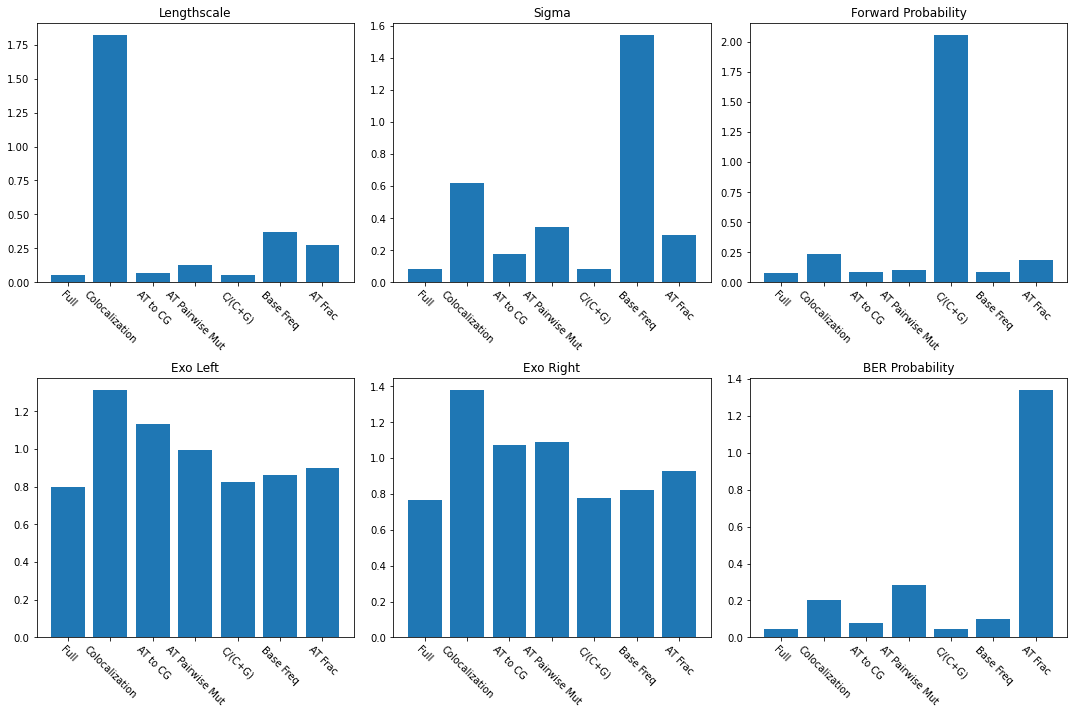

In [127]:
hist_labels = ['Full', 'Colocalization', 'AT to CG', 'AT Pairwise Mut','C/(C+G)','Base Freq','AT Frac']
y_pos = range(len(hist_labels))
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
  
# For Sine Function
axis[0, 0].bar(y_pos,[shuffle[i][0] for i in range(7)])
axis[0, 0].set_title("Lengthscale")
axis[0,0].set_xticks(y_pos, hist_labels, rotation=-45)
# For Cosine Function
axis[0, 1].bar(y_pos,[shuffle[i][1] for i in range(7)])
axis[0, 1].set_title("Sigma")
axis[0,1].set_xticks(y_pos, hist_labels, rotation=-45)
# For Tangent Function
axis[0, 2].bar(y_pos,[shuffle[i][2] for i in range(7)])
axis[0, 2].set_title("Forward Probability")
axis[0,2].set_xticks(y_pos, hist_labels, rotation=-45)
# For Sine Function
axis[1, 0].bar(y_pos,[shuffle[i][3] for i in range(7)])
axis[1, 0].set_title("Exo Left")
axis[1,0].set_xticks(y_pos, hist_labels, rotation=-45)
# For Cosine Function
axis[1, 1].bar(y_pos,[shuffle[i][4] for i in range(7)])
axis[1, 1].set_title("Exo Right")
axis[1,1].set_xticks(y_pos, hist_labels, rotation=-45)
# For Tangent Function
axis[1, 2].bar(y_pos,[shuffle[i][5] for i in range(7)])
axis[1, 2].set_title("BER Probability")
axis[1,2].set_xticks(y_pos, hist_labels, rotation=-45)
figure.set_figheight(10)
figure.set_figwidth(15)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
#plt.savefig('figures/scatter.png')
plt.show()

In [25]:
np.std(train_X, axis =0)

array([2.88424117e+00, 2.30133878e+00, 2.17435839e+00, 1.71882336e+00,
       1.67730199e+00, 1.86240195e+00, 1.55836728e+00, 1.40141528e+00,
       1.45213297e+00, 1.26482567e+00, 1.19081987e+00, 1.13737806e+00,
       1.07186485e+00, 1.01321821e+00, 1.02771820e+00, 9.51972662e-01,
       8.72856052e-01, 8.23107900e-01, 7.93194887e-01, 7.88571217e-01,
       7.64727143e-01, 7.21376635e-01, 6.81462358e-01, 6.58671799e-01,
       6.28989801e-01, 5.98747277e-01, 5.85864820e-01, 5.54400240e-01,
       5.28929783e-01, 5.35376360e-01, 5.23309208e-01, 4.96414328e-01,
       4.80072186e-01, 4.55588977e-01, 4.31467369e-01, 4.15144630e-01,
       4.04297939e-01, 3.89384312e-01, 3.79864703e-01, 3.75876707e-01,
       3.57151459e-01, 3.48250442e-01, 3.39544193e-01, 3.20657670e-01,
       3.13911523e-01, 3.06770423e-01, 3.05234220e-01, 3.01733395e-01,
       2.90477224e-01, 2.86099960e-01, 2.83558335e-01, 2.76276449e-01,
       2.78340745e-01, 2.71465426e-01, 2.58719679e-01, 2.62120120e-01,
      

In [64]:
np.shape(test_X)

(900, 105)

In [3]:
pd.read_csv('../kevin_data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R.csv')

,Unnamed: 0,sample_id,family,orig_seq,mut_seq,branch_length,v_call,v_int_start,v_int_end,v_start_pos,v_diff
0,0,316188,1810,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,9.965000e-07,IGHV4,65,293,65,0
1,1,316188,1810,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,9.965000e-07,IGHV4,65,293,65,0
2,2,316188,1810,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,6.856857e-03,IGHV4,65,293,65,0
3,3,316188,1810,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1.378499e-02,IGHV4,65,293,65,0
4,4,316188,1810,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,CAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCGG...,9.965000e-07,IGHV4,65,293,65,0
...,...,...,...,...,...,...,...,...,...,...,...
84317,84317,326713,7218,GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...,GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...,1.008400e-06,IGHV3,65,294,63,0
84318,84318,326713,7218,GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,3.446953e-03,IGHV3,65,294,63,0
84319,84319,326713,7218,GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,6.921136e-03,IGHV3,65,294,63,0
84320,84320,326713,7218,GAGGTGCAGCTGGTGGAGTCCGGGGGAGGCTTAGTTCAGCCTGGGG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,6.907990e-03,IGHV3,65,294,63,0


In [10]:
import pandas as pd
path = './s5f/sim_data/data' # use your path
all_files = glob.glob(os.path.join(path , "*.csv"))
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=None)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)


In [11]:
frame.columns = ['mut', 'orig']

In [12]:
s5f_set = frame.drop_duplicates(subset=['orig'])
len(s5f_set)

26

In [13]:
muts = []
for i in s5f_set['orig']:
    num = np.zeros(len(i))
    temp_ss = frame[frame['orig'] == i]
    for index, row in temp_ss.iterrows():
        num += np.array([float(a1 != a2) for (a1,a2)  in (zip(row['mut'],row['orig'])) if len(row['mut']) == len(row['orig'])])
    muts.append(num/len(temp_ss))

In [14]:
s5f = pd.read_csv('./s5f/5mers.csv', sep='\t')
def get_5mer(seq, pos):
    return seq[(pos-2):(pos+3)]

In [15]:
s5f_dict_num = {i:0 for i in s5f['Motif']}
s5f_dict_deno = {i:0 for i in s5f['Motif']}
df = pd.read_pickle("sim_data/full_edge_df.pk1")

In [16]:
s5f_dict_num = {i:0 for i in s5f['Motif']}
s5f_dict_deno = {i:0 for i in s5f['Motif']}
for i in range(len(df)):
    for j in range(len(df['orig_seq'][i])-4):
        mer = get_5mer(df['orig_seq'][i],j+2)
        if df['orig_seq'][i][j+2]!= df['mut_seq'][i][j+2]:
            s5f_dict_num[mer] += 1
        s5f_dict_deno[mer] += 1

In [17]:
s5f_mut_probs = {i:s5f_dict_num[i]/s5f_dict_deno[i] for i in s5f_dict_num.keys()}

In [18]:
def disambiguate(motif: str):
        """Expands ambiguous motif to a list of concrete motifs"""
        idx = motif.find("N")
        if idx < 0:
            return [motif]
        else:
            motifs = []
            for l in disambiguate(motif[:idx]):
                for r in disambiguate(motif[idx + 1 :]):
                    for ch in "ACGT":
                        motifs.append(l + ch + r)
            return motifs

In [19]:
def get_mut(muts, seq):
    mut_seq = np.zeros(len(seq))
    buff_seq = "NN"+ seq + "NN"
    for i in range(len(buff_seq)- 4):
        if buff_seq[i:i+5].find('N') >= 0:
            mut_seq[i] = np.mean([s5f_mut_probs[i] for i in disambiguate(buff_seq[i:i+5])])
        else:
            mut_seq[i] = s5f_mut_probs[buff_seq[i:i+5]]
    return mut_seq

In [20]:
s5f_seq_muts = []
for i in s5f_set['orig']:
    s5f_seq_muts.append(get_mut(s5f_mut_probs,i))

In [21]:
def log_loss(y_true,y_pred):
    y_pred = np.minimum(y_pred, 0.999)
    y_pred = np.maximum(y_pred,.001)
    return -1.0*(y_true*np.log(y_pred)+ (1-y_true)*np.log(1-y_pred))

In [22]:
counter = 0
s5f_losses = []
shmpy_losses = []
null_losses = []
for i in s5f_set['orig']:
    s5f_mut = s5f_seq_muts[counter]
    shmpy_mut = muts[counter]
    frame_ss = df[df['orig_seq'] == i]
    for j in frame_ss.iterrows():
        diffs = np.array([int(j[1]['mut_seq'][k] != j[1]['orig_seq'][k]) for k in range(len(j[1]['orig_seq']))])
        s5f_losses.append(log_loss(diffs,s5f_mut))
        shmpy_losses.append(log_loss(diffs,shmpy_mut))
        null_losses.append(log_loss(diffs,np.repeat(num/deno, len(diffs))))
    counter+=1

NameError: name 'deno' is not defined

In [ ]:
round(np.mean(np.concatenate(s5f_losses)),4)

0.0315

In [ ]:
round(np.mean(np.concatenate(shmpy_losses)),4)

0.0345

In [ ]:
round(np.mean(np.concatenate(null_losses)),4)

0.0343

In [ ]:
len(s5f_seq_muts)

26

In [ ]:
np.random.binomial(np.ones(len(s5f_seq_muts[0]),dtype = int), s5f_seq_muts[0])

4

In [22]:
mut_seqs = [[] for i in range(26)]
for i in range(10000):
    for j in range(26):
        mut_seqs[j].append(np.random.binomial(np.ones(len(s5f_seq_muts[j]),dtype = int), s5f_seq_muts[j]))

In [23]:
num = np.zeros(100)
deno = np.zeros(100)
for i in range(26):
    for k in range(100):
        for j in range(len(s5f_seq_muts[i])-k):
            p1 = np.array([t[j] for t in mut_seqs[i]])
            p2 = np.array([t[j+k] for t in mut_seqs[i]])
            num[k] += (np.mean(p1*p2))/(s5f_seq_muts[i][j]* s5f_seq_muts[i][j+k])
            deno[k] += 1


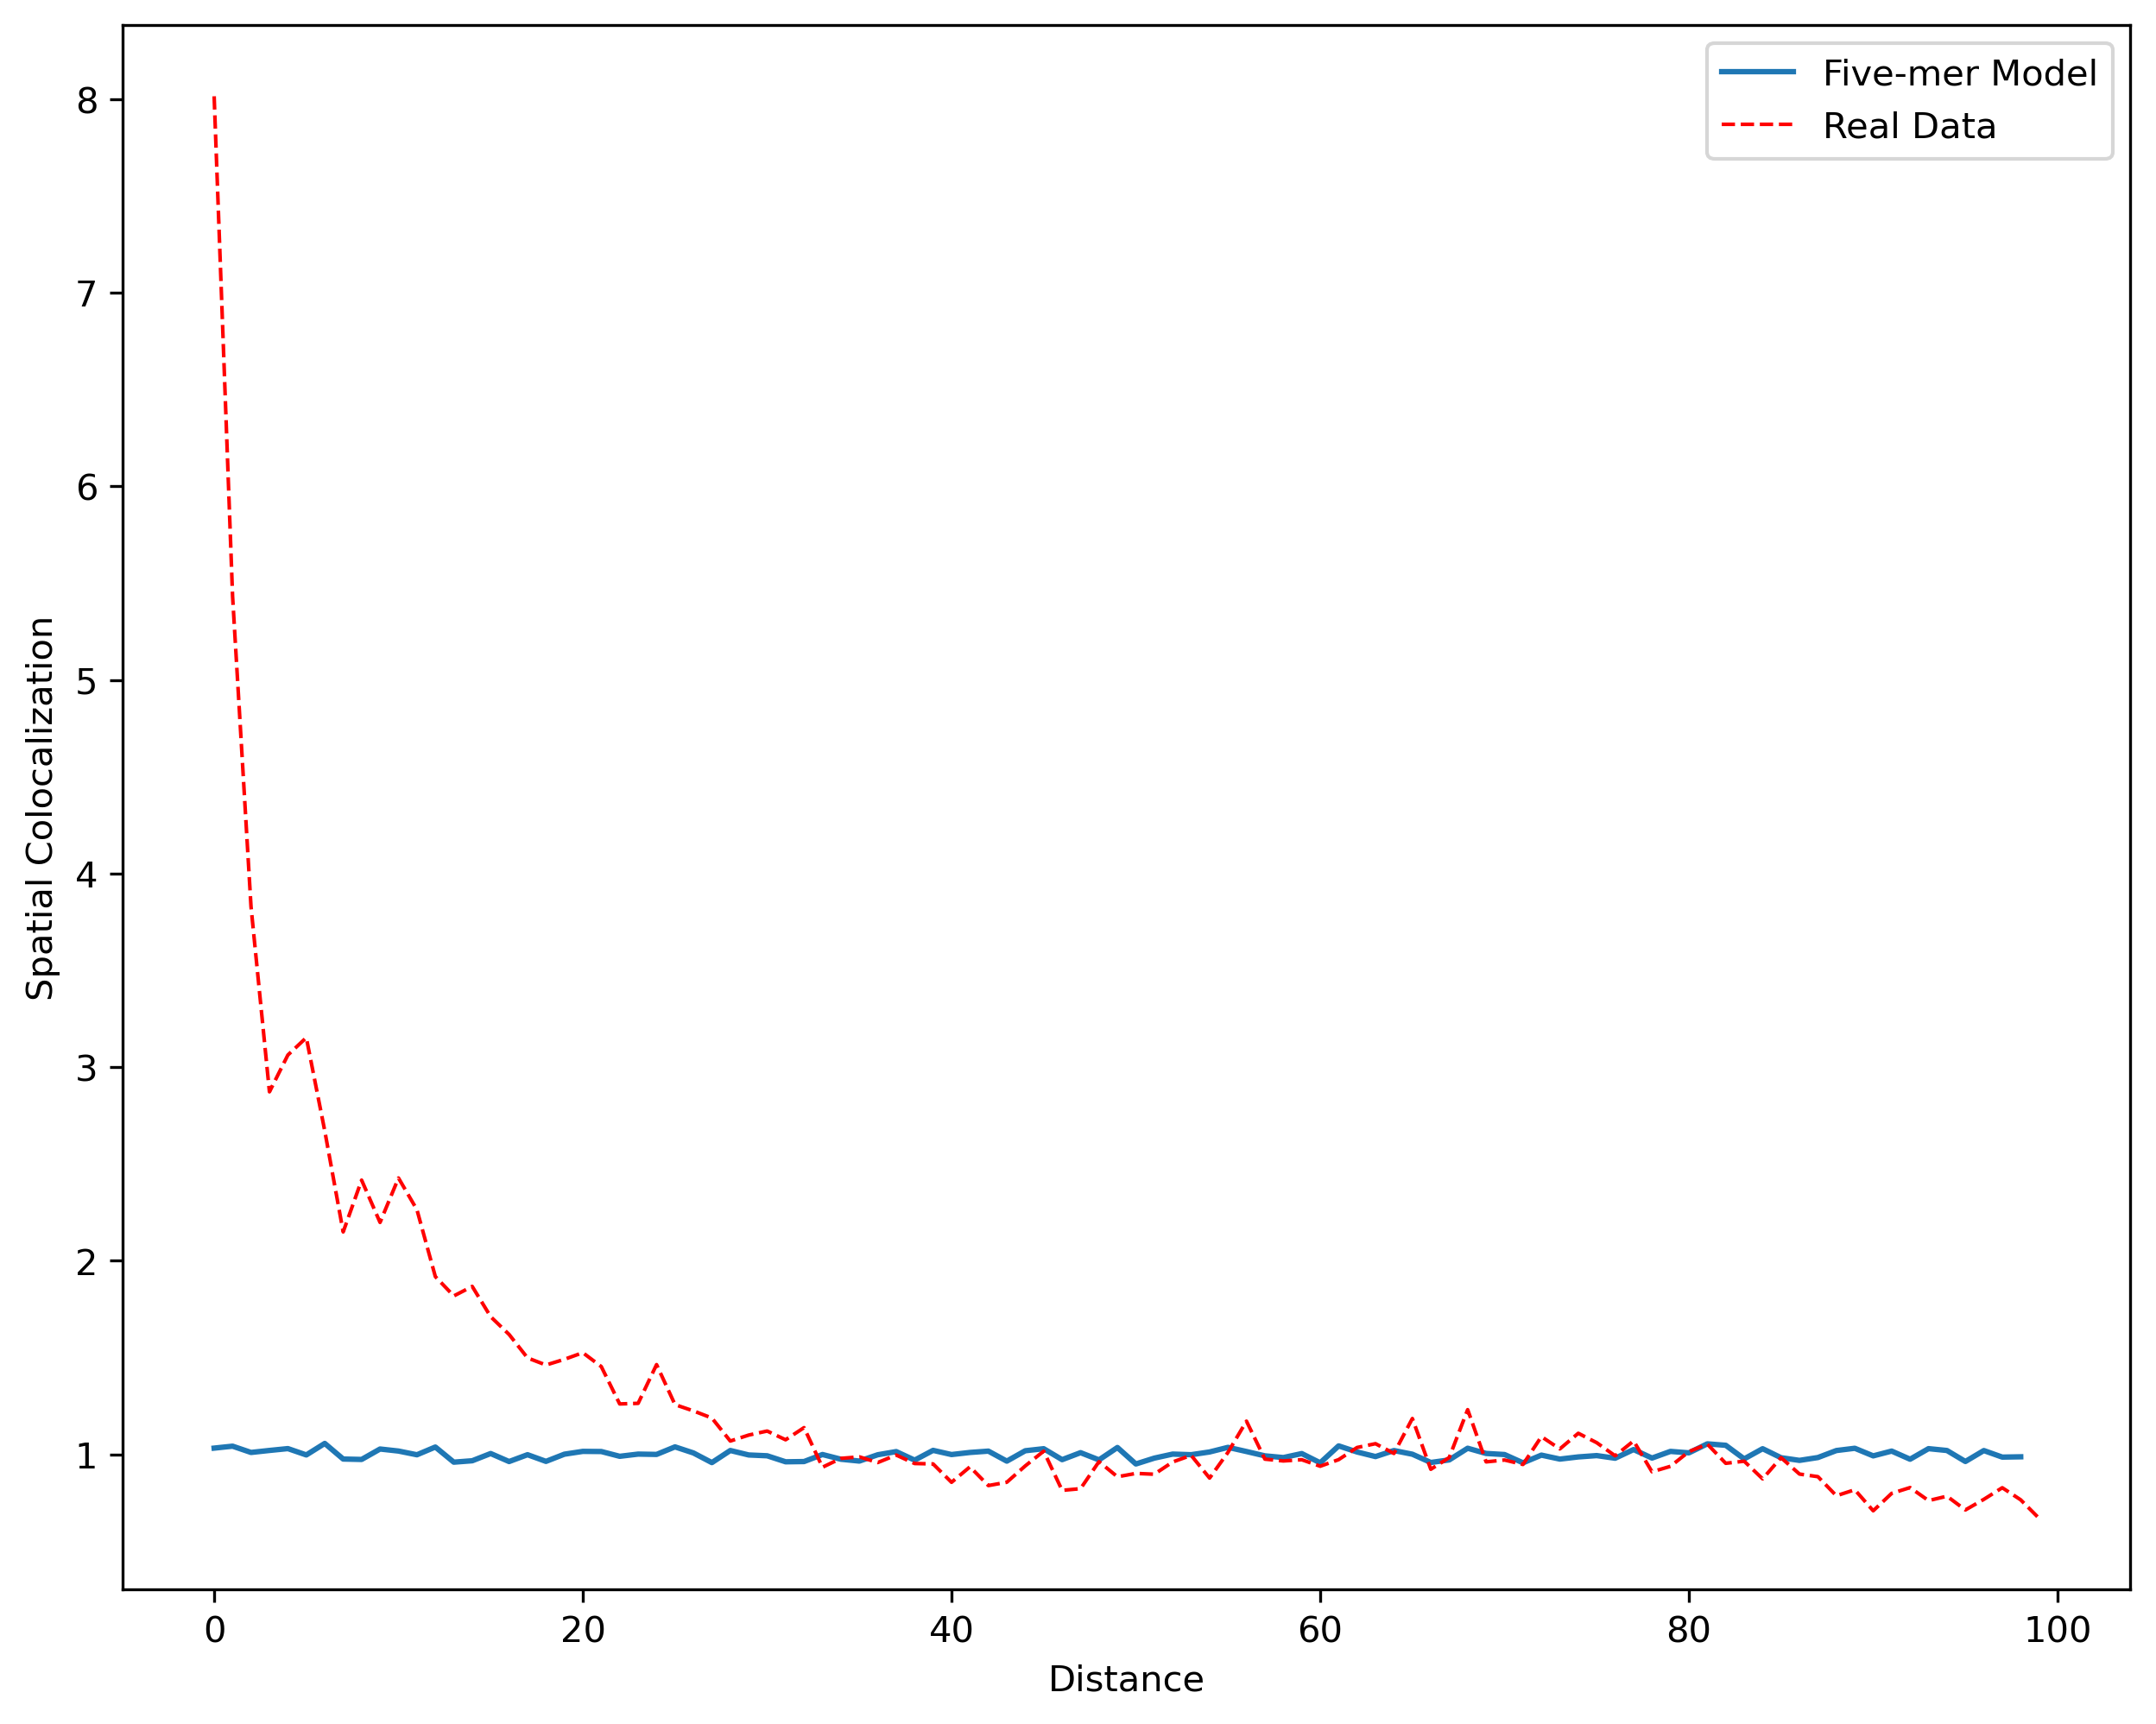

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8),dpi = 300)
plt.plot(num[1:]/deno[1:])
num_5mer = num[1:]
deno_5mer = deno[1:]
plt.plot(summ_stat[0:100], color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Distance')
plt.ylabel('Spatial Colocalization')
plt.legend(['Five-mer Model','Real Data'])

In [6]:
# Load our stuff
import numpy as np
from Bio import SeqIO
from SHMModels.simulate_mutations import *
from SHMModels.fitted_models import ContextModel
import pkgutil
import logging
import os
import sys
import json
import random
from scipy.stats import norm
import csv
import collections
from scipy.stats import norm
# Load options
import pandas as pd
import glob
from random import sample
from sim_data.sumstats import *
from sim_data.params import *
import math
import os
import torch
import torch.nn as nn

# Load df with all seqs
df = pd.read_pickle("./sim_data/data/full_edge_df.pk1")
parent_sequences = df['orig_seq']
run = sys.argv[0]
cm = ContextModel(3, 2, pkgutil.get_data("SHMModels", "data/aid_goodman.csv"))

train_batch_size = 25
train_data_size = 500
num_seqs = 500


def hot_encode_dna_sequences(sequences):
    bases = ['A', 'C', 'G', 'T']
    num_bases = len(bases)
    
    # Create a dictionary to map bases to indices
    base_to_index = {base: index for index, base in enumerate(bases)}
    
    # Get the maximum length of the sequences
    max_length = max(len(seq) for seq in sequences)
    
    # Initialize an empty matrix to store the hot encoded sequences
    encoded_sequences = np.zeros((len(sequences), max_length, num_bases), dtype=int)
    
    # Iterate over each sequence and hot encode it
    for i, seq in enumerate(sequences):
        for j, base in enumerate(seq):
            if base in base_to_index:
                encoded_sequences[i, j, base_to_index[base]] = 1
            else:
                # Handle unrecognized bases as desired (e.g., ignore or treat as zeros)
                pass
    
    return encoded_sequences

# Get batch (BER AND POL ETA DEFINED HERE)
def gen_batch_letters(seq,batch_size, params):
       # The prior specification
    ber_prob = params['ber_prob']
    ber_params = [0.25,0.25,0.25,0.25]
    
    bubble_size = 25.0
    pol_eta_params = {
        "A": [0.9, 0.02, 0.02, 0.06],
        "G": [0.01, 0.97, 0.01, 0.01],
        "C": [0.01, 0.01, 0.97, 0.01],
        "T": [0.06, 0.02, 0.02, 0.9],
    }
    prior_params = params
    exo_left = 1.0/prior_params['exo_left']
    exo_right = 1.0/prior_params['exo_right']
    mutated_seq_list = []
    for i in range(batch_size):
          mr = MutationRound(
          seq,
          ber_lambda=1.0,
          mmr_lambda=(1 - ber_prob)/ber_prob,
          replication_time=100,
          bubble_size=bubble_size,
          aid_time=10,
          exo_params={"left": exo_left, "right": exo_right},
          pol_eta_params=pol_eta_params,
          ber_params=ber_params,
          p_fw= prior_params['p_fw'],
          aid_context_model=cm,
          log_ls = prior_params['lengthscale'],
          sg = prior_params['gp_sigma'],
          fw_br = prior_params['fw_br'],
          rc_br = prior_params['rc_br'],
          off = prior_params['gp_offset']
          )
          mr.mutation_round()
          mutated_seq_list.append(SeqRecord(mr.repaired_sequence, id=""))
    return [list(i.seq) for i in mutated_seq_list]
# Generate batch of Param, Seq batch pairs
def gen_batch(batch_size, num_seqs, parent_sequences):
    X_par = []
    X_chi = []
    theta = []
    for i in range(batch_size):
        true_model_params = sample_prior()
        true_params_array = np.array((true_model_params['lengthscale'],
                                     true_model_params['gp_sigma'],
                                     true_model_params['p_fw'],
                                     true_model_params['exo_left'],
                                     true_model_params['exo_right'],
                                     true_model_params['ber_prob']))
        obs_sample = []
        parent_sample = sample(list(parent_sequences),num_seqs)
        for i in range(num_seqs):
            t_seq = gen_batch_letters(Seq(parent_sample[i]),1, true_model_params)
            obs_sample.append(t_seq[0])
        X_chi.append(hot_encode_dna_sequences(obs_sample))
        X_par.append(hot_encode_dna_sequences(parent_sample))
        theta.append(true_params_array)
    return X_chi,X_par,theta


train_X_chi,train_X_par, train_theta = gen_batch(train_data_size, num_seqs,parent_sequences)

training = [train_X_chi[i]-train_X_par[i] for i in range(len(train_X_chi))]
length = np.max([np.shape(i)[1] for i in train_X_chi])

for i in range(len(training)):
    if np.shape(training[i])[1] < length:
        dist = length - np.shape(training[i])[1]
        training[i] = np.concatenate((training[i],np.zeros((num_seqs,dist,4))), axis = 1)



class AttentionModel(nn.Module):
    def __init__(self, seq_length, conv_filters,
                 dropout):
        super().__init__()
        self.seq_length = seq_length
        self.conv_filters = conv_filters
        self.device = device

        self.dropout = nn.Dropout(p=dropout)

        self.conv = nn.Conv2d(1,self.conv_filters,(10,4), padding = 'same')
        self.enclayer = nn.TransformerEncoderLayer(d_model= 4*self.conv_filters, nhead = 1, dim_feedforward= 128,batch_first=True)
        self.linear = nn.Linear(self.seq_length*self.conv_filters*4, out_features= 256)
    def forward(self, x):

        x = x.to(self.device) 

        conv_out = self.conv(x)
        conv_out = torch.reshape(conv_out,(-1,self.seq_length,4*self.conv_filters))
        attn_out = self.enclayer(conv_out)
        attn_out = torch.reshape(attn_out, (-1,self.seq_length*self.conv_filters*4))
        out = self.linear(attn_out)
        return out



cuda


In [8]:
model = AttentionModel(length,10, 0.0)

In [9]:
model.load_state_dict(stater)

<All keys matched successfully>

In [11]:
model.cuda()

AttentionModel(
  (dropout): Dropout(p=0.0, inplace=False)
  (conv): Conv2d(1, 10, kernel_size=(10, 4), stride=(1, 1), padding=same)
  (enclayer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
    )
    (linear1): Linear(in_features=40, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=128, out_features=40, bias=True)
    (norm1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (linear): Linear(in_features=16960, out_features=256, bias=True)
)

In [42]:
batch_preds = []
for i in range(50):
    print(i)
    idx = range((10*i),(10*i+10))
    batch_training = [training[i] for i in idx]
    training_tensors = [torch.reshape(torch.tensor(i).float(), (num_seqs,1,length,4)).cuda() for i in batch_training]
    embeds = [torch.mean(model(i),0) for i in training_tensors]
    preds = linear(torch.stack(embeds))
    batch_preds.append(preds.cpu().detach().numpy())
    del training_tensors
    del embeds
    del preds

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [44]:
batch_preds_shift = [i*np.std(train_theta,axis = 0) + np.mean(train_theta,axis = 0) for i in batch_preds]
preds = np.array(batch_preds_shift).reshape((500,6))
labels = np.array(train_theta).reshape((500,6))

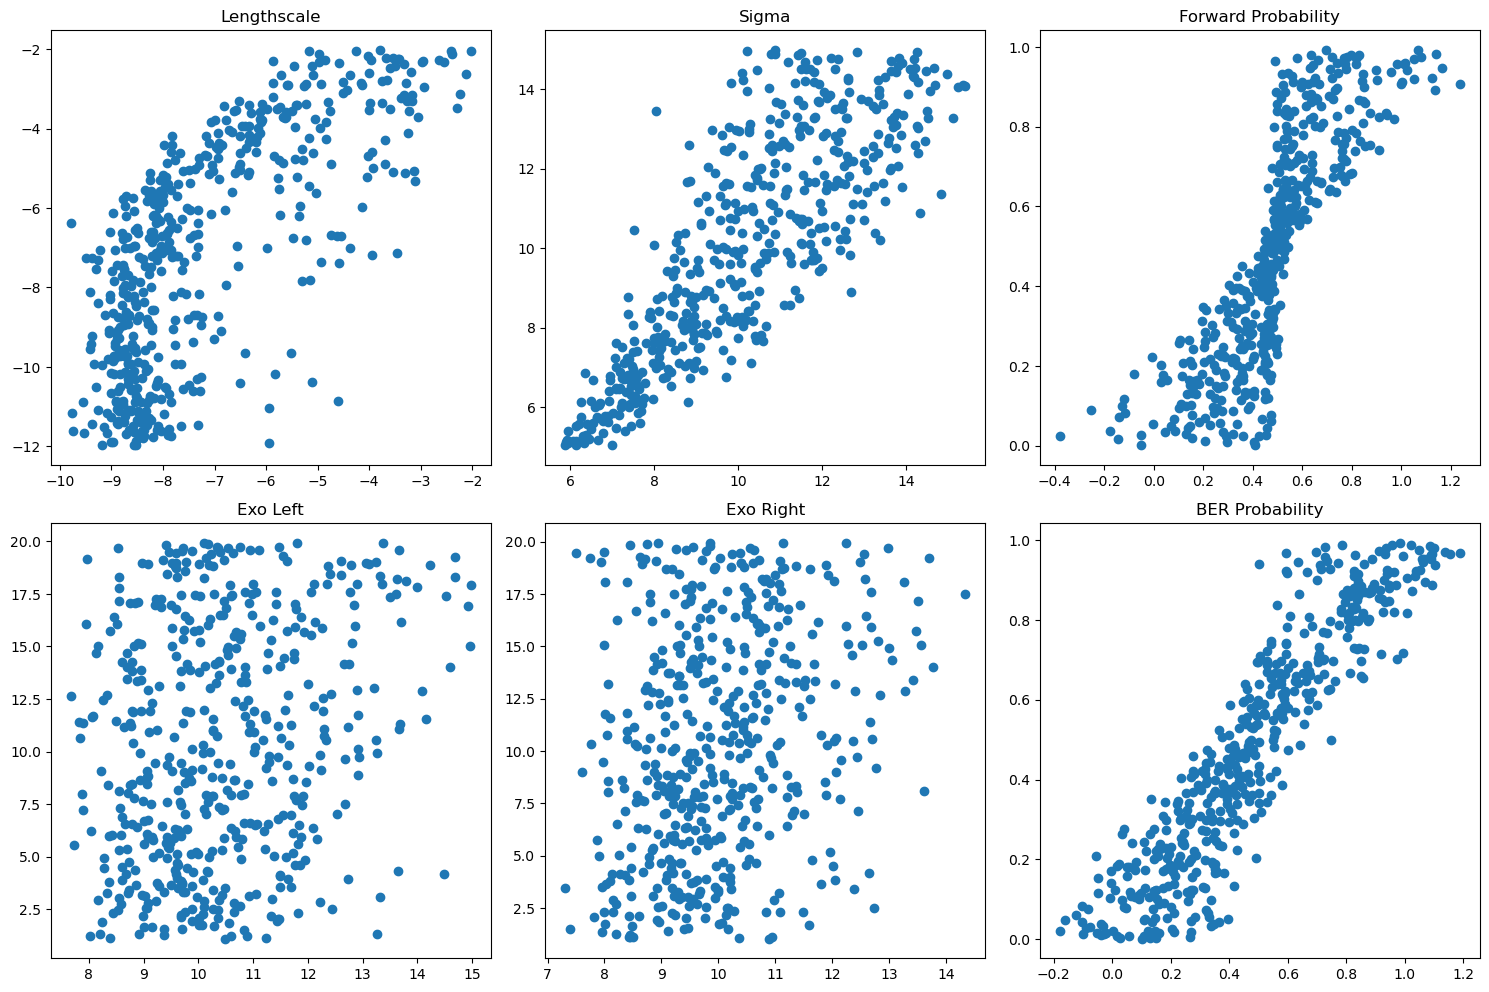

In [45]:
import matplotlib.pyplot as plt
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
  
axis[0, 0].scatter(preds[:,0], labels[:,0])
axis[0, 0].set_title("Lengthscale")
  
axis[0, 1].scatter(preds[:,1], labels[:,1])
axis[0, 1].set_title("Sigma")
  
axis[0, 2].scatter(preds[:,2], labels[:,2])
axis[0, 2].set_title("Forward Probability")
  

axis[1, 0].scatter(preds[:,3], labels[:,3])
axis[1, 0].set_title("Exo Left")
  

axis[1, 1].scatter(preds[:,4], labels[:,4])
axis[1, 1].set_title("Exo Right")
  

axis[1, 2].scatter(preds[:,5], labels[:,5])
axis[1, 2].set_title("BER Probability")
figure.set_figheight(10)
figure.set_figwidth(15)
figure.tight_layout(pad=1.0)
# Combine all the operations and display
plt.savefig('figures/scatter.png')
plt.show()


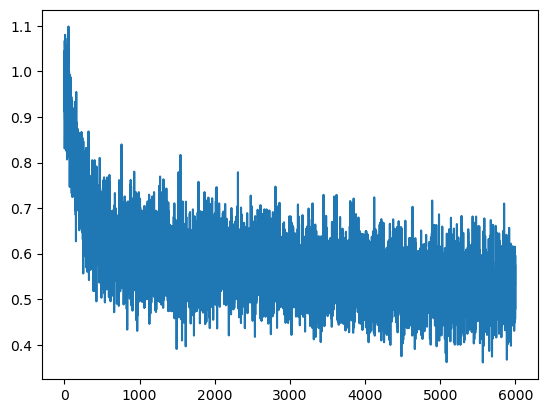

In [6]:
import numpy as np
import matplotlib.pyplot as plt
losses = np.load('sim_data/preds/losses.npy')
plt.plot(losses)

In [43]:
torch.cuda.empty_cache()